# Synthesis example: Classifying Viruses and Bacteria

Author: Adam Rivers

## Classifying sequences by their tetranucleotide frequencies

In this example we are going to classify Viral and Bacterial nucleotide sequences  using their tetranucleotide frequencies or 4-mers.

Kmers are counted by moving a sliding window of length (k=4) along a DNA sequence:

```
TCGGATTTTTAA
TCGA
 CGAT
  GATT
   ATTT
    TTTT
     TTTT
      TTTA
       TTAA
```

kmer | count | frequency
------|----- | --------
TCGA | 1 | 0.125
CGAT | 1 | 0.125
GATT | 1 | 0.125
ATTT | 1 | 0.125
TTTT | 2 | 0.250
TTTA | 1 | 0.125
TTAA | 1 | 0.125

## Selecting training data

To build a good classifier it is essential to sample training from a population representative of the population to be classified. This is a big challenge when working with sequencing data because the genomes that humans choose to sequence are not representative of the organisms in the environment.  We spend lots of time sequencing the organisms that make us sick.

This data has been carefully selected to take this into account.  We have selected about the same number of samples from every different family of bacteria and virus, then we extracted 5000 nucleotide long fragments from each genome.

## Information bleed over 

We know that we never want to evaluate our model using the training data. We always reserve a separate set of test data for evaluation. What happens though if some test data is almost exactly the same as our training data?  Let's say we have a Salmonella genome of the same type  in the test and the train sets? In this case we may artificially inflate the performance of our classifier. 

To avoid this issue in this example we have made sure that if an example is in the test set no organisms from that taxonomic family  are present in the test set. This gives us a realistic estimate of how well the classifier will perform at classifying a virus at the family level.


This is a common mistake in ML methods. Several papers have been published on this exact application that split data randomly or split test and training data by the date they were added to the RefSeq database.







## Logistic regression model
We will use these counts to classify the reads as viral or bacterial using a **_Logistic Regression_**. model (actually a type of classifier not a regressor).


First lets load in our training data.


In [30]:
# Import pandas
import pandas as pd
import sys

path_tdb = "../nb-datasets/kmer/train/2.simple.csv.gz"
path_tdv = "../nb-datasets/kmer/train/10239.simple.csv.gz"
    
# Load in the raw training data for bacteria using pd.read_csv
train_data_b = pd.read_csv(path_tdb, header=None)

# add a label to indicate bacteria = 0 
train_data_b['label'] = 0

# Load in the raw Training data for viruses
train_data_v =  pd.read_csv(path_tdv, header=None)

# add a label to indicate viruses = 1 
train_data_v['label'] =  1

# combine the training data together with pd.concat([])

train_data = pd.concat([train_data_b, train_data_v])

# Shuffle your training data with sample(frac=1). This is really important for methods that train in batches
train_data = train_data.sample(frac=1)
# Now we will divide all samples by the sum. This is how short kmer frequencies  are typically reported.

#select the columns with features
train_data_x = train_data.iloc[:,1:257]

# divide train_data_x by train data.sum(axis=1)
train_data_x_scaled = train_data_x.div(train_data_x.sum(axis=1), axis=0)

#view the data
train_data_x_scaled.head()

,1,2,3,4,5,6,7,8,9,10,...,247,248,249,250,251,252,253,254,255,256
19690,0.003922,0.002876,0.004314,0.001700,0.001307,0.004445,0.005229,0.001961,0.003791,0.004184,...,0.008106,0.002092,0.002484,0.005622,0.004053,0.001307,0.000523,0.003661,0.004706,0.003922
50879,0.030640,0.008533,0.011894,0.022495,0.007111,0.004783,0.002456,0.009825,0.010601,0.001810,...,0.006593,0.009308,0.008016,0.002586,0.008016,0.009179,0.014221,0.015126,0.013575,0.030640
12437,0.008121,0.005285,0.005800,0.005543,0.004383,0.004898,0.005543,0.003609,0.006058,0.005156,...,0.005156,0.006316,0.005543,0.005672,0.007476,0.003867,0.003996,0.006316,0.006316,0.008121
66450,0.014319,0.009288,0.007611,0.013287,0.009417,0.003483,0.002967,0.007998,0.006579,0.003870,...,0.002838,0.009417,0.008385,0.004386,0.006192,0.008385,0.010062,0.011481,0.008514,0.014319
7329,0.004758,0.005144,0.006173,0.002958,0.005530,0.004501,0.003344,0.006173,0.007845,0.003601,...,0.006559,0.006559,0.005787,0.004501,0.004630,0.006173,0.001672,0.007202,0.005401,0.004758


In [31]:
train_data_x_scaled.shape

(179480, 256)

Take a look at the univariate distributions of some of the features

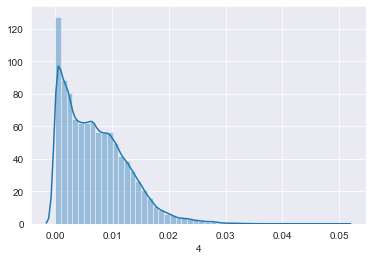

In [32]:
# Import plotting library Seaborn
import seaborn as sns
sns.set_style('darkgrid')

# plot some features (change the "3" to see more) with train_data_scaled.iloc[:,X]
sns.distplot(train_data_x_scaled.iloc[:,3])

That's not very normal.  Let's see how our classifier performs. 

In [43]:
# Load the testing data

# Load in raw test data for bacteria

test_data_b = pd.read_csv("../nb-datasets/kmer/test/2.simple.csv.gz", header=None)

# add a label to indicate bacteria = 0 
test_data_b['label'] = 0

# Load in raw test data for viruses
test_data_v = pd.read_csv("../nb-datasets/kmer/test/10239.simple.csv.gz", header=None)

# add a label to indicate viruses = 1 
test_data_v['label'] = 1

# combine the test data together with pd.concat([])
test_data = pd.concat([test_data_b ,test_data_v])
# Shuffle your test data. This only matters if you use a portion of your test data to evaluate performance.
test_data = test_data.sample(frac=1)

# Now we will divide all samples by the sum. this is how short kmer frequencies are typically reported.
test_data_x = test_data.iloc[:,1:257]
test_data_x_scaled = test_data_x.div(test_data_x.sum(axis=1), axis=0)

#view the data
test_data_x.shape

(23655, 256)

### Run the model

We will fit a logistic regression model with L1 regularization

In [35]:
from sklearn import linear_model

# convert our data into Numpy arrays 
X = train_data_x_scaled.to_numpy()
y = train_data["label"].to_numpy()

# Define the Logistic model parameters
clf = linear_model.LogisticRegression(max_iter=1000, random_state=0, solver='lbfgs', C=1)

# Fit the model (here's where the learning learning is happening) 
clf.fit(X,y)

# convert our test data into Numpy arrays
testX = test_data_x_scaled.to_numpy()
testy = test_data["label"].to_numpy()

# Estimate the accuracy
print("Accuracy :")
clf.score(testX, testy)

Accuracy :


0.9191291481716339

That's okay accuracy, Remember though that our data is not a 50% split between viruses and bacteria. The test data has 16,175 bacteria and 7,480 viruses. If we made a classifier that just assigned everything the label of bacteria it would be have an accuracy of 

$$\frac{16175}{16175 + 7480} = 0.683$$

This is actually a common issue with using accuracy as a metric on imbalanced data. We will discuss better metrics soon.


## Transforming data 

The next step is to try to normalize our data in a more sophisticated manner.

First think about 4-mers themselves. A few key insights are:

1. The total number of kmers does not matter since that just equals the sequence length (except in the accuracy of our frequency measurement).
2. The number of every kmer is affected by the number of every other kmer since kmers are mutually exclusive

These attributes describe **_compositional count data_**. Compositional data has an established set of transformations that can be used to move it into the real number space expected by most ML models.

The general steps are:

1. Close the dataset (make is sum to a constant)
2. Estimate the value of any 0's in count data
4. Take the Isometric log ratio with respect to an orthonormal basis



In [4]:
import comp

# First repalce any 0's with small values
xmrp = comp.multiplicative_replacement(X)
xclr = comp.clr(xmrp)

NameError: name 'X' is not defined

In [36]:
# import a Scikit Bio library for compositional data transformations

import skbio.stats.composition

# Close the dataset train_data_x
train_clo = skbio.stats.composition.closure(X)

# repalce Zeros using multiplcative replacement
train_z = skbio.stats.composition.multiplicative_replacement(train_clo)

#  Perform an Isometric logratio transformation
train_ilr = skbio.stats.composition.ilr(train_z)

Take a look at the univariate distributions of some of the features

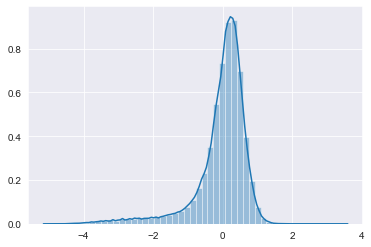

In [37]:
import seaborn as sns
sns.set_style('darkgrid')
sns.distplot(train_ilr[:,3])

In [44]:
# Transform the test data

test_clo = skbio.stats.composition.closure(test_data_x)
test_z = (test_cskbio.stats.composition.multiplicative_replacementlo)
test_ilr = skbio.stats.composition.ilr(test_z)
test_ilr.shape


(23655, 255)

Now evaluate the model with the transformed data


In [45]:
from sklearn import linear_model

Xc = train_ilr
yc = train_data["label"].to_numpy()


clf = linear_model.LogisticRegression(max_iter= 1000, random_state=0, solver='lbfgs', C=1)
clf.fit(Xc, yc)

testXc = test_ilr
testyc = test_data["label"].to_numpy()

# Estimate the accuracy
print("Accuracy :")
clf.score(testXc, testyc) 


Accuracy :


0.9330796871697316

93% Accuracy, we've improed our classifier by transforming the data
## Parameter tuning 

LEts look at the options you can specify when setting up a [logistic regression model in Scikit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)


```{python}
class sklearn.linear_model.LogisticRegression(penalty=’l2’,
                                              dual=False,
                                              tol=0.0001, 
                                              C=1.0, 
                                              fit_intercept=True, 
                                              intercept_scaling=1, 
                                              class_weight=None, 
                                              random_state=None, 
                                              solver=’warn’, 
                                              max_iter=100, 
                                              multi_class=’warn’, 
                                              verbose=0, 
                                              warm_start=False, 
                                              n_jobs=None, 
                                              l1_ratio=None)
```

A couple of these are very important:
    
**`penalty`**: this controls for overfitting by **_regularization_**

There are two basic types of regularization l1 and l2.

* l1 (Lasso) regularization: drops some features out of the model
* l2 (Ridge) regularization: reduces the importance of some features with a weighting term

The parameter `C` controls how strongly the data should be regularized

* Smaller values of `c` mean stronger regularization.

We can find optimal settings for our dataset by trying multiple settings of parameters using the convenient function `LogisticRegressionCV`.  By setting `Cs=10` we specifying that the solver try 10 different values of C between 1e-4 and 1e4.



In [11]:

# Cs=[.01,.03,0.1,0.3,1, 3]


# Estimate the accuracy
print("Accuracy :")


Accuracy :


In this case the parameter sweep did not improve the classifier the prediction.


# Classifier evaluation

Often it is useful to look at how the tradeoff between identfying a virus and 

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.95')

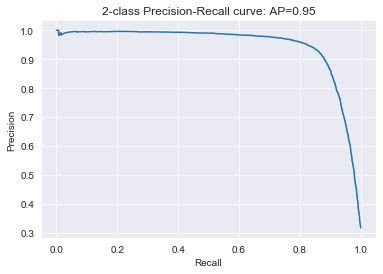

In [48]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

# Retrieve the scores from the logistic regression model
y_score = clf.decision_function(testXc)

# Calulate the aveage precision
average_precision = average_precision_score(testyc, y_score)

precision, recall, _ = precision_recall_curve(testyc, y_score)
sns.lineplot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [14]:
#Plot Our coefficient distrubution


In [13]:
# tid|508441|NC_036579.1|pos|102368..106368,
